# 1.Preprocess Data
I use scikit-learn to preprocess data and Glove to initialize word vectors

## 1.1 Load data from text files

In [39]:
from xml.etree.ElementTree import fromstring

with open("D:/CS584/Assignment_4/a4-data/q2/negative.review") as f:
    negative = f.read();
with open("D:/CS584/Assignment_4/a4-data/q2/positive.review") as f:
    positive = f.read();

## 1.2 get content of <review text>

In [40]:
import re
import numpy

def get_text_from_element(xml_string):
    prog = re.compile(r"<review_text>(?P<review_text>.*?)</review_text>", re.S)
    return prog.findall(xml_string)

positive = get_text_from_element(positive)
negative = get_text_from_element(negative)

In [41]:
def merge(samples, paragraphs):
    paragraphs.append(samples)

paragraphs = []
types = []

for index in range(1000):
    paragraphs.append(positive[index])
    types.append(1)
    paragraphs.append(negative[index])
    types.append(0)

## 1.5 Tokenize the data

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(paragraphs)
tokenized_sentence = tokenizer.texts_to_sequences(paragraphs)

Find the length distribution of sentences

95% of sentence length are under:493


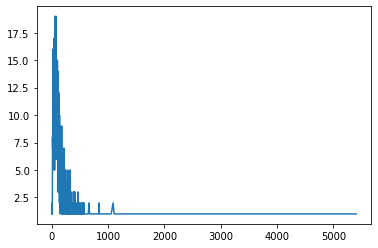

In [43]:
from matplotlib.pylab import plot

sentence_lengths_count = dict()
for sentence in tokenized_sentence:
    if sentence_lengths_count.get(len(sentence)) is None:
        sentence_lengths_count[len(sentence)] = 1
    else:
        sentence_lengths_count[len(sentence)] = sentence_lengths_count[len(sentence)] + 1
        
lists = sorted(sentence_lengths_count.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) 
plot(x, y)

temp = 0
index = 0
while temp < 2000*0.95:
    temp+=y[index]
    index = index+1
length_95percent = x[index]
print("95% of sentence length are under:"+str(length_95percent))

Only keep the sentence that have length under 95%, which is 493

In [44]:
window_size = 20

def make_same_length(tokenized_sentence, types):
    new_tokenized_sentence = []
    new_types = []
    for i in range(len(tokenized_sentence)):
        sentence = tokenized_sentence[i]
        if len(sentence) > length_95percent:
            continue
        while len(sentence) < length_95percent:
            sentence.append(0)
        new_tokenized_sentence.append(sentence)
        new_types.append(types[i])
    return new_tokenized_sentence, new_types
            
tokenized_sentence, types = make_same_length(tokenized_sentence, types)
total_paragraph = len(tokenized_sentence)

## 1.4 Determine range of training and test


In [45]:
import numpy

tokenized_sentence = numpy.array(tokenized_sentence)
types = numpy.array(types)

train_x = tokenized_sentence[0:int(0.8*total_paragraph)]
train_y = types[0:int(0.8*total_paragraph)]

test_x = tokenized_sentence[int(0.8*total_paragraph):total_paragraph]
text_y = types[int(0.8*total_paragraph):total_paragraph]

## 1.5 Load GloVe vectors

In [46]:
embeddings_dict = {}
with open("D:/CS584/glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = numpy.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

num_tokens = len(tokenizer.index_word) + 2

embedding_params = numpy.ones(shape=(num_tokens, 50),dtype="float32")
for i in range(len(tokenizer.index_word)):
    word = tokenizer.index_word[i+1]
    if word in embeddings_dict:
        embedding_params[i] = embeddings_dict[word]

# 2. Define LSTM and CNN

# 2.1 LSTM model

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, GlobalAveragePooling1D, BatchNormalization, Masking
from tensorflow.keras.initializers import Constant

def get_lstm_model(embedding_params):
    model = Sequential()
    model.add(Masking(0))
    model.add(Embedding(input_dim=num_tokens, output_dim=50,
                        embeddings_initializer=Constant(embedding_params)))
    model.add(Bidirectional(LSTM(128, return_sequences=True), merge_mode='ave'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    return model

batch_size = 30

lstm_model = get_lstm_model(embedding_params)
lstm_model.build((batch_size, window_size))
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          multiple                  0         
_________________________________________________________________
embedding_7 (Embedding)      multiple                  1179800   
_________________________________________________________________
bidirectional_4 (Bidirection multiple                  183296    
_________________________________________________________________
batch_normalization_10 (Batc multiple                  512       
_________________________________________________________________
global_average_pooling1d_4 ( multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  129       
Total params: 1,363,737
Trainable params: 1,363,481
Non-trainable params: 256
__________________________________________

## 2.2 CNN model

In [48]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D


def get_cnn_model(embedding_params):
    model = Sequential()
    model.add(Masking(0))
    model.add(Embedding(input_dim=num_tokens, output_dim=50,
                        embeddings_initializer=Constant(embedding_params)))
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool1D(3))
    model.add(Conv1D(filters=32, kernel_size=3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    return model

cnn_model = get_cnn_model(embedding_params)
cnn_model.build((batch_size, window_size))
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          multiple                  0         
_________________________________________________________________
embedding_8 (Embedding)      multiple                  1179800   
_________________________________________________________________
conv1d_6 (Conv1D)            multiple                  9664      
_________________________________________________________________
batch_normalization_11 (Batc multiple                  256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 multiple                  0         
_________________________________________________________________
conv1d_7 (Conv1D)            multiple                  6176      
_________________________________________________________________
batch_normalization_12 (Batc multiple                 

# 3. Train and test model

## 3.1 Train LSTM

In [49]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-3)

lstm_model.compile(optimizer=opt,
                  loss='binary_crossentropy')
lstm_model.fit(train_x,
               train_y,
               epochs=25,
               shuffle=True,
               verbose=2)
lstm_model.save('lstm_model_bi.h5')

Train on 1521 samples
Epoch 1/25
1521/1521 - 6s - loss: 0.6938
Epoch 2/25
1521/1521 - 3s - loss: 0.6562
Epoch 3/25
1521/1521 - 3s - loss: 0.5425
Epoch 4/25
1521/1521 - 3s - loss: 0.4063
Epoch 5/25
1521/1521 - 3s - loss: 0.2962
Epoch 6/25
1521/1521 - 3s - loss: 0.2521
Epoch 7/25
1521/1521 - 3s - loss: 0.1948
Epoch 8/25
1521/1521 - 3s - loss: 0.1904
Epoch 9/25
1521/1521 - 2s - loss: 0.1732
Epoch 10/25
1521/1521 - 3s - loss: 0.1426
Epoch 11/25
1521/1521 - 3s - loss: 0.1308
Epoch 12/25
1521/1521 - 3s - loss: 0.0784
Epoch 13/25
1521/1521 - 3s - loss: 0.0816
Epoch 14/25
1521/1521 - 3s - loss: 0.0613
Epoch 15/25
1521/1521 - 3s - loss: 0.0719
Epoch 16/25
1521/1521 - 3s - loss: 0.0597
Epoch 17/25
1521/1521 - 3s - loss: 0.0670
Epoch 18/25
1521/1521 - 3s - loss: 0.0453
Epoch 19/25
1521/1521 - 3s - loss: 0.0411
Epoch 20/25
1521/1521 - 3s - loss: 0.0395
Epoch 21/25
1521/1521 - 3s - loss: 0.0340
Epoch 22/25
1521/1521 - 3s - loss: 0.0305
Epoch 23/25
1521/1521 - 3s - loss: 0.0141
Epoch 24/25
1521/1521

## 3.2 Train CNN

In [50]:
opt = Adam(learning_rate=1e-3)
cnn_model.compile(optimizer=opt,
                  loss='binary_crossentropy')
cnn_model.fit(train_x,
               train_y,
               epochs=10,
               shuffle=True,
               verbose=2)
cnn_model.save('cnn_model_bi.h5')

Train on 1521 samples
Epoch 1/10
1521/1521 - 1s - loss: 1.8018
Epoch 2/10
1521/1521 - 1s - loss: 0.5353
Epoch 3/10
1521/1521 - 1s - loss: 0.3229
Epoch 4/10
1521/1521 - 1s - loss: 0.1758
Epoch 5/10
1521/1521 - 1s - loss: 0.0864
Epoch 6/10
1521/1521 - 1s - loss: 0.0388
Epoch 7/10
1521/1521 - 1s - loss: 0.0213
Epoch 8/10
1521/1521 - 1s - loss: 0.0149
Epoch 9/10
1521/1521 - 1s - loss: 0.0087
Epoch 10/10
1521/1521 - 1s - loss: 0.0065


## 3.3 Test LSTM and CNN

In [51]:
from tensorflow.keras.models import load_model
lstm_model = load_model('lstm_model_bi.h5')
cnn_model = load_model('cnn_model_bi.h5')

In [52]:
from sklearn.metrics import recall_score, f1_score, precision_score

def predict(x):
    result = []
    for xi in x:
        if xi > 0.5:
            xi = 1
        else:
            xi = 0
        result.append(xi)
    return numpy.array(result)

pred_y = predict(lstm_model.predict(test_x))


lstm_f1 = f1_score(text_y, pred_y, average='binary')
lstm_re = recall_score(text_y, pred_y, average='binary')
lstm_pr = precision_score(text_y, pred_y, average='binary')

In [53]:
pred_y = predict(cnn_model.predict(test_x))

cnn_f1 = f1_score(text_y, pred_y, average='binary')
cnn_re = recall_score(text_y, pred_y, average='binary')
cnn_pr = precision_score(text_y, pred_y, average='binary')

In [54]:
print("lstm: F1="+str(lstm_f1)+" recall="+str(lstm_re)+" precision="+str(lstm_pr))
print("cnn: F1="+str(cnn_f1)+" recall="+str(cnn_re)+" precision="+str(cnn_pr))

lstm: F1=0.7902439024390244 recall=0.84375 precision=0.7431192660550459
cnn: F1=0.6447876447876448 recall=0.8697916666666666 precision=0.5122699386503068


## 3.4 Table

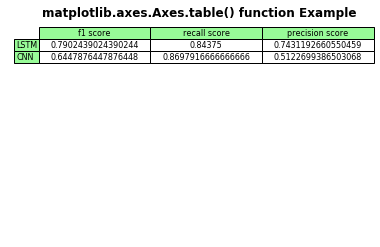

In [55]:
import matplotlib.pyplot as plt 
  
val1 = ["f1 score", "recall score", "precision score"] 
val2 = ["LSTM", "CNN"] 
val3 = [[lstm_f1,lstm_re,lstm_pr],
        [cnn_f1,cnn_re,cnn_pr]] 
  
fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = val2,  
    colLabels = val1, 
    rowColours =["palegreen"] * 10,  
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')         
  
ax.set_title('matplotlib.axes.Axes.table() function Example', 
             fontweight ="bold") 
  
plt.show() 



